## 1. Use DBSCAN to cluster the data.

In [3]:
import pandas as pd
import csv
import numpy as np
df = pd.read_csv('processed_data.csv', index_col=0)


# Step 1: Extract numerical features
data = df.select_dtypes(include=[np.number])
# removing ordinal feature 'ID'
data.drop('ID', axis=1, inplace=True)
data_numpy = data.to_numpy()
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,processed_value,processed_release_clause,processed_wage,processed_joining,processed_contract_valid,processed_height,processed_weight,processed_LS,processed_ST,processed_RS,processed_LW,processed_LF,processed_CF,processed_RF,processed_RW,processed_LAM,processed_CAM,processed_RAM,processed_LM,processed_LCM,processed_CM,processed_RCM,processed_RM,processed_LWB,processed_LDM,processed_CDM,processed_RDM,processed_RWB,processed_LB,processed_LCB,processed_CB,processed_RCB,processed_RB
0,31,94,94,2202,5.0,4.0,4.0,10.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,110500.0,226500.0,565.0,2004.0,2021.0,170.18,159.0,88.00000,88.00000,88.00000,92.00000,93.00000,93.00000,93.00000,92.00000,93.000000,93.000000,93.000000,91.00000,84.000000,84.000000,84.000000,91.00000,64.000000,61.000000,61.000000,61.000000,64.000000,59.000000,47.000000,47.000000,47.000000,59.000000
1,33,94,94,2228,5.0,4.0,5.0,7.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,77000.0,127100.0,405.0,2018.0,2022.0,187.96,183.0,91.00000,91.00000,91.00000,89.00000,90.00000,90.00000,90.00000,89.00000,88.000000,88.000000,88.000000,88.00000,81.000000,81.000000,81.000000,88.00000,65.000000,61.000000,61.000000,61.000000,65.000000,61.000000,53.000000,53.000000,53.000000,61.000000
2,26,92,93,2143,5.0,5.0,5.0,10.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,118500.0,228100.0,290.0,2017.0,2022.0,175.26,150.0,84.00000,84.00000,84.00000,89.00000,89.00000,89.00000,89.00000,89.00000,89.000000,89.000000,89.000000,88.00000,81.000000,81.000000,81.000000,88.00000,65.000000,60.000000,60.000000,60.000000,65.000000,60.000000,47.000000,47.000000,47.000000,60.000000
3,27,91,93,1471,4.0,3.0,1.0,1.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,72000.0,138600.0,260.0,2011.0,2020.0,193.04,168.0,57.81547,57.81547,57.81547,59.03765,58.71939,58.71939,58.71939,59.03765,58.983129,58.983129,58.983129,59.73471,58.220878,58.220878,58.220878,59.73471,57.513274,56.825146,56.825146,56.825146,57.513274,56.806786,55.614626,55.614626,55.614626,56.806786
4,27,91,92,2281,4.0,5.0,4.0,7.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,102000.0,196400.0,355.0,2015.0,2023.0,180.34,154.0,82.00000,82.00000,82.00000,87.00000,87.00000,87.00000,87.00000,87.00000,88.000000,88.000000,88.000000,88.00000,87.000000,87.000000,87.000000,88.00000,77.000000,77.000000,77.000000,77.000000,77.000000,73.000000,66.000000,66.000000,66.000000,73.000000


In [4]:
data_numpy.shape

(18207, 75)

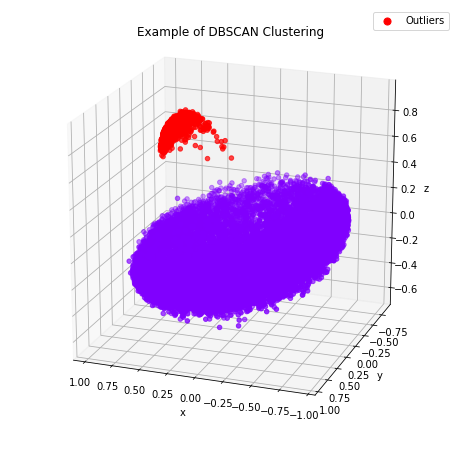

In [5]:
from sklearn.cluster import DBSCAN
import numpy as np

# The clustering hyperparameters


# Visualizing using PCA
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

eps = 0.4
min_samples =  300

X = data
# Scaling the data so that all the features become comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

pca = PCA(n_components=3)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2', 'P3']
#X_principal = X_normalized

# Applying DBSCAN here
clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='euclidean').fit(X_principal)#data_numpy)



outliers = X_principal.to_numpy()[np.where(clustering.labels_ == -1)]
#clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='euclidean').fit(X_principal)
fig = plt.figure(figsize=(8,8),)
ax = fig.add_subplot(projection="3d")

ax.scatter(X_principal['P1'], X_principal['P2'], X_principal['P3'],c = clustering.labels_, cmap ='rainbow' )#s=100)
ax.scatter(outliers[:,0], outliers[:,1], outliers[:,2],c='red', label="Outliers",s=50 ,alpha=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20,110)
plt.title("Example of DBSCAN Clustering")
plt.legend(loc="upper right")
plt.show()

# Optimal value of epsilon, and MinPoints


## MinPoints choice

### To find optimal value of epsilon, and MinPoints we refer to the research paper https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf (Page 11, Section 4.1)

### They suggest to keep the min points at 4 for most datasets, and only for those dataset which has a lot of noise it should be kept at 2*dimension. 

### Since we have already reduced the dimension to 3 using PCA, we expect a less noisier data, and hence we can keep the min points at 4.



## Epsilon choice Approach 1

### The paper also mentions clearly that inorder to find the epsilon effectively domain knowledge is required, but without domain knowledge one can try the following.

### 1) We first plot the sorted k-nearest neighbours distance graph.

### 2) We then look for a knee in the graph. This knee can be taken as an epsilon.

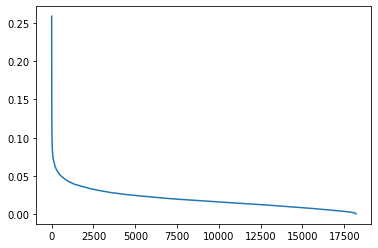

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

N = 4
NN = NearestNeighbors(n_neighbors=N,radius=10)
NN_fit = NN.fit(X_principal)#.to_numpy())
X = data_numpy.copy()
#X = StandardScaler().fit_transform(data_numpy)
distances, indices = NN_fit.kneighbors(X_principal)#.to_numpy())
distances = -np.sort(-distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

### No clear knee is being observed, but it looks like it is below 0.05, hence we have to zoom into this region to observe more closely.

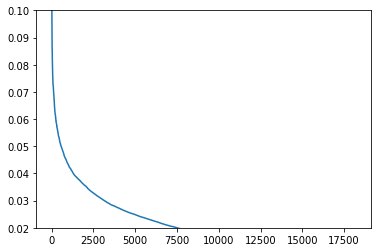

In [7]:
plt.ylim(0.02,0.1)
plt.plot(distances)

### A mildly visible knee is being observed at 0.04. Hence taking epsilon as 0.04

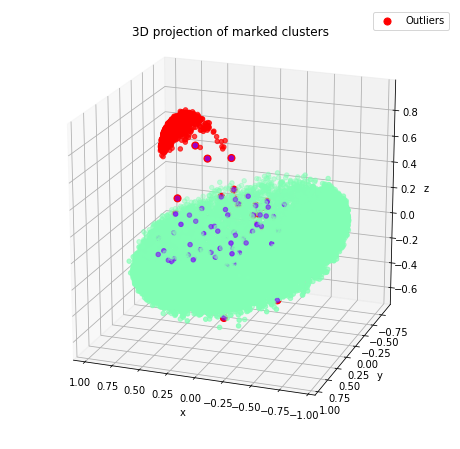

In [8]:
eps = 0.1
min_samples =  7

X = data
# Scaling the data so that all the features become comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that the data approximately follows a Gaussian distribution
#X_normalized = normalize(X_scaled)
X = data_numpy.copy()
pca = PCA(n_components=3)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2', 'P3']
#X_principal = X_normalized

# Applying DBSCAN here
clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='euclidean').fit(X_principal)#data_numpy)
tup = np.unique(clustering.labels_, return_counts=True)



outliers = X_principal.to_numpy()[np.where(clustering.labels_ == -1)]
#clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='euclidean').fit(X_principal)
fig = plt.figure(figsize=(8,8),)
ax = fig.add_subplot(projection="3d")

ax.scatter(X_principal['P1'], X_principal['P2'], X_principal['P3'],c = clustering.labels_, cmap ='rainbow' )#s=100)
ax.scatter(outliers[:,0], outliers[:,1], outliers[:,2],c='red', label="Outliers",s=50 ,alpha=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20,110)
plt.title("3D projection of marked clusters")
plt.legend(loc="upper right")
plt.show()

### Question) Is it able to classify messy, and ronaldo as an outlier?
Yes

In [9]:
print(clustering.labels_[0]) #Cluster label corresponding to messi
print(clustering.labels_[1]) #Cluster label corresponding to ronaldo

0
0


### As both have the label -1 they are both being classified as an outlier.

In [10]:
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1]), array([   64, 16120,  2023]))

## Epsilon Choice approach 2, please note that this is also just a heuristics

The above heuristic approach although followed from research paper is not giving good scores, so in order to maximize the scores we come up with a different approach that also involves elbow plot plotting.

In [11]:
min_samples = 4

eps = 0.01
increment = 0.01
max_eps = 0.2

scores = []

while(eps < max_eps):
  
  clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='euclidean').fit(X_principal)#data_numpy)
  if(len(clustering.labels_) == 1):
    scores.append(-1)
  X_without_outlier = X_principal[clustering.labels_ != -1]
  true_labels = clustering.labels_[clustering.labels_ != -1]
  score = silhouette_score(X_without_outlier, true_labels)
  scores.append(score)
  eps += increment
  print(eps)


0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004


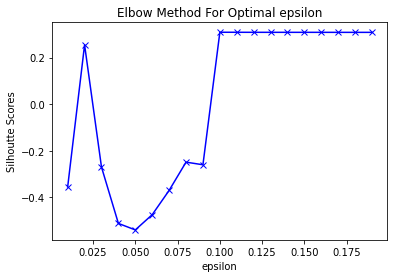

In [12]:
K = np.arange(0.01,0.2, 0.01)
plt.plot(K, scores, 'bx-')
plt.xlim
plt.xlabel('epsilon')
plt.ylabel('Silhoutte Scores')
plt.title('Elbow Method For Optimal epsilon')
plt.show()

## We choose epsilon = 0.1, and plot the aquired clusters.

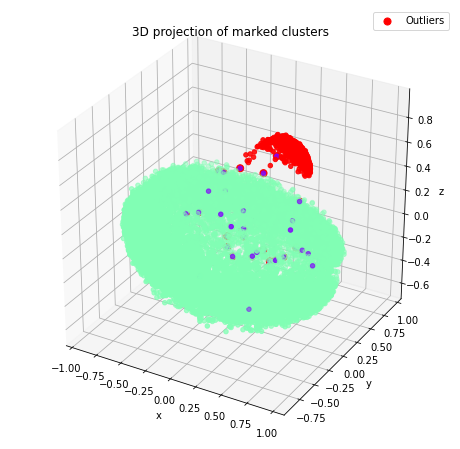

In [13]:
eps = 0.1
min_samples =  4


# Applying DBSCAN here
clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='euclidean').fit(X_principal)#data_numpy)
tup = np.unique(clustering.labels_, return_counts=True)



outliers = X_principal.to_numpy()[np.where(clustering.labels_ == -1)]
#clustering = DBSCAN(eps = eps, min_samples=min_samples, metric='euclidean').fit(X_principal)
fig = plt.figure(figsize=(8,8),)
ax = fig.add_subplot(projection="3d")

ax.scatter(X_principal['P1'], X_principal['P2'], X_principal['P3'],c = clustering.labels_, cmap ='rainbow' )#s=100)
ax.scatter(outliers[:,0], outliers[:,1], outliers[:,2],c='red', label="Outliers",s=50 ,alpha=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(80,100)
plt.title("3D projection of marked clusters")
plt.legend(loc="upper right")
plt.show()

## Cluster analysis

### Silhoutte Coefficient

The Silhouette Coefficient is an example of an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

* a: The mean distance between a sample and all other points in the same class.

* b: The mean distance between a sample and all other points in the next nearest cluster.

In [14]:
X_without_outlier = X_principal[clustering.labels_ != -1]
true_labels = clustering.labels_[clustering.labels_ != -1]
print("Silhoutee result for DBSCAN is" , silhouette_score(X_without_outlier, true_labels))

Silhoutee result for DBSCAN is 0.30905644588417897


### Calinski-Harabasz index

If the ground truth labels are not known, the Calinski-Harabasz index- also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

In [15]:
# Checking the Calinski-Harabasz Index with above clstering labels.
X_without_outlier = X_principal[clustering.labels_ != -1]
true_labels = clustering.labels_[clustering.labels_ != -1]
print(metrics.calinski_harabasz_score(X_without_outlier, true_labels))

4063.067788329381


### Davies-Bouldin index
 The Davies-Bouldin index can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [16]:
# Checking the davies_bouldin Index with above clstering labels.
print(metrics.davies_bouldin_score(X_without_outlier, true_labels))

0.7691404120146493


### Determining the most similar attributes of the cluster.

In [17]:
df = data
df['result'] = np.array(clustering.labels_)

In [18]:
df['result'].value_counts()

 0    16151
 1     2023
-1       33
Name: result, dtype: int64

In [19]:
df_0 = df[df['result']==0]
df_1 = df[df['result']==1]

In [20]:
for column in data.columns:
    print("Mean values for feature ", column, " across 3 clusters are: ")
    print(df_0[column].mean())
    print(df_1[column].mean())

Mean values for feature  Age  across 3 clusters are: 
25.000619156708563
26.03361344537815
Mean values for feature  Overall  across 3 clusters are: 
66.45223205993437
64.58032624814632
Mean values for feature  Potential  across 3 clusters are: 
71.50752275400905
69.78002965892239
Mean values for feature  Special  across 3 clusters are: 
1667.115410810476
1045.6999505684628
Mean values for feature  International Reputation  across 3 clusters are: 
1.115375807101659
1.0939199209095403
Mean values for feature  Weak Foot  across 3 clusters are: 
3.0047347127288266
2.4893722194760257
Mean values for feature  Skill Moves  across 3 clusters are: 
2.5323721630376146
1.0
Mean values for feature  Jersey Number  across 3 clusters are: 
19.426511136357536
20.486676270772815
Mean values for feature  Crossing  across 3 clusters are: 
54.19492543539658
14.244686109738012
Mean values for feature  Finishing  across 3 clusters are: 
49.74097230802451
12.018783984181908
Mean values for feature  HeadingAc

### The first cluster has the players who earns the maximum wages, and have way better skills then those in the second cluster.
## Example of such players are Messi, and Ronaldo

### Second cluster has the players who are better at goal keeping, if we look at the mean values they are way better in goal keeping then the players in first cluster.

In [21]:
# An example of first cluster is 

print(clustering.labels_[0]+1) # Label corresponding to messi
print(clustering.labels_[1]+1) # Label corresponding to ronaldo

1
1
